In [15]:
from langgraph.graph import START, END, StateGraph
from IPython.display import display, Image
from typing_extensions import Literal, TypedDict
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
from langchain_ollama import ChatOllama

In [16]:
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(None, description='The next step in the routing process')
        
llm = ChatOllama(model="qwen2.5:7b", base_url="http://localhost:11434")
router = llm.with_structured_output(Route)

In [17]:
class State(TypedDict):
    input: str
    decision: str
    output: str
        

# Nodes
def llm_call_1(state: State):
    """写一个笑话"""
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state: State):
    """写一个故事"""
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state: State):
    """写一篇诗句"""
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state: State):
    decision = router.invoke(
        [
            SystemMessage(content="通过用户输入的信息，将其路由到 story、joke、poem。"),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision": decision.step}

# 编写边的条件
def route_decision(state: State):
    if state["decision"] == "joke":
        return "llm_call_1"
    elif state["decision"] == "story":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

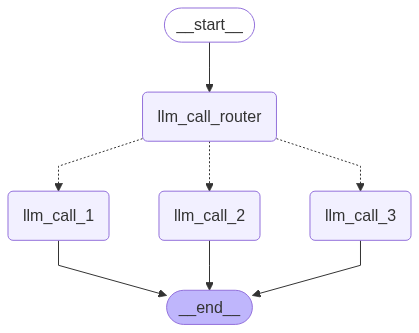

In [18]:
router_builder = StateGraph(State)

# 添加节点
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)


# 添加边
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    }
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

router_workflow = router_builder.compile()
display(Image(router_workflow.get_graph().draw_mermaid_png()))


In [ ]:
state = router_workflow.invoke({"input": "写一篇关于猫的笑话"})
print(state["output"])

#state = router_workflow.invoke({"input": "写一篇关于猫的故事"})
#state["output"]

#state = router_workflow.invoke({"input": "写一篇关于猫的七言绝句"})
#state["output"]